**Changes** - The data directories should be located directly in the data folder, not in subfolders by month. The load_data() function takes in the path to the data directory and the language to filter by (None returns all languages). It returns the data from the directories as a dataframe. I also added some additional data fields from the XML files to the dataframe.

In [40]:
import json
import os
import collections
import io
import numpy as np
import xmltodict
import pandas as pd
import json
import matplotlib.pyplot as plt
import urllib.request
%matplotlib inline

* [TED Schemas](https://publications.europa.eu/en/web/eu-vocabularies/tedschemashttps://publications.europa.eu/en/web/eu-vocabularies/tedschemas)
* [Forms in PDF ](http://simap.ted.europa.eu/standard-forms-for-public-procurement)
* [Daily Notices](https://data.europa.eu/euodp/data/dataset/ted-1/resource/0eec3f91-27f1-4ce0-91d2-102d82cb97ec)

In [2]:
data_path = "./data"

def load_data(data_path, language="EN"):
    # get the list of the subdirectories
    dirs = os.listdir(data_path)
    parsed_xmls = []
    
    language_tenders = []
    all_tenders = []
    
    # loop through the subdirectories and get the list of files in each
    for dir_ in dirs:
        files = os.listdir(os.path.join(data_path, dir_))
        date = dir_.split("_")[0]
        
        # loop through the files
        for file in files:
            # read the contents of the file
            with io.open(os.path.join(data_path, dir_, file), 'r', encoding="utf-8") as f:
                xml = f.read()
                parsed_xml = xmltodict.parse(xml)
                parsed_xmls.append(parsed_xml)
                forms_section = parsed_xml['TED_EXPORT']['FORM_SECTION']
                notice_data = parsed_xml['TED_EXPORT']['CODED_DATA_SECTION']['NOTICE_DATA']
                codif_data = parsed_xml['TED_EXPORT']['CODED_DATA_SECTION']['CODIF_DATA']
                
                forms = forms_section.keys()
                
                for form in forms:
                    try:
                        form_contents = forms_section[form]
                        form_contents['DATE'] = date
                        form_contents['FILE'] = file
                        form_contents['NO_DOC_OJS'] = notice_data['NO_DOC_OJS']
                        form_contents['ORIGINAL_CPV_CODE'] = notice_data['ORIGINAL_CPV']['@CODE']
                        form_contents['ORIGINAL_CPV_TEXT'] = notice_data['ORIGINAL_CPV']['#text']
                        form_contents['VALUE'] = notice_data['VALUES']['VALUE']['#text']
                        form_contents['VALUE_CURR'] = notice_data['VALUES']['VALUE']['@CURRENCY']
                        form_contents['REF_NO'] = notice_data['REF_NOTICE']['NO_DOC_OJS']
                        
                        if isinstance(form_contents, list):
                            for i, form_contents in enumerate(fred):
                                all_tenders.append(form_contents[i])
                                if language is not None and form_contents['@LG'] == language:
                                    language_tenders.append(form_contents[i])
                        elif isinstance(form_contents, collections.OrderedDict):
                            all_tenders.append(form_contents)
                            if language is not None and form_contents['@LG'] == language:
                                language_tenders.append(form_contents)
                    except Exception as e:
                        pass

    if language == None:
        language_tenders = all_tenders

    parsed_data = []
    for tender in language_tenders:
        flattened = {}
        
        # add some fields
        flattened['DATE'] = tender['DATE']
        flattened['LG'] = tender['@LG']
        flattened['FILE'] = tender['FILE']
        flattened['NO_DOC_OJS'] = tender['NO_DOC_OJS']
        flattened['ORIGINAL_CPV_CODE'] = tender['ORIGINAL_CPV_CODE']
        flattened['ORIGINAL_CPV_TEXT'] = tender['ORIGINAL_CPV_TEXT']
        flattened['VALUE'] = tender['VALUE']
        flattened['VALUE_CURR'] = tender['VALUE_CURR']
        flattened['REF_NO'] = tender['REF_NO']
        try:
            for key, value in tender['CONTRACTING_BODY'].items():
                address_contracting_body = value
                try:
                    for key, value in address_contracting_body.items():
                        flattened[key.lower()] = value
                except:
                    pass
            
            flattened['title'] = tender['OBJECT_CONTRACT']['TITLE']['P']
            flattened['short_description'] = tender['OBJECT_CONTRACT']['SHORT_DESCR']['P']
            
            # unwind some fields
            flattened['country'] = flattened['country']['@VALUE']
            flattened['n2016:nuts'] = flattened['n2016:nuts']['@CODE']
            
            parsed_data.append(flattened)
        except Exception as e:
#             print("error:", e)
            pass

    df = pd.DataFrame(parsed_data)

    return df

In [3]:
df = load_data(data_path, language=None)

In [4]:
df.head()

,@value,DATE,FILE,LG,NO_DOC_OJS,ORIGINAL_CPV_CODE,ORIGINAL_CPV_TEXT,REF_NO,VALUE,VALUE_CURR,...,nationalid,officialname,p,phone,postal_code,short_description,title,town,url_buyer,url_general
0,GENERAL_PUBLIC_SERVICES,20190102,000025_2019.xml,ES,2019/S 001-000025,45215100,Construction work for buildings relating to he...,2018/S 188-423874,46944466.16,EUR,...,Q1500376G,"Registro General de la Xunta de Galicia, edifi...",NaN,+34 981544516,15781,Ampliación del Hospital Arquitecto Marcide en ...,Ejecución de las obras de la fase 1 del Comple...,Santiago de Compostela,NaN,http://www.xunta.gal
1,GENERAL_PUBLIC_SERVICES,20190102,000080_2019.xml,BG,2019/S 001-000080,45212212,Construction work for swimming pool,2018/S 139-316766,1628092.65,BGN,...,000852697,Община Каварна,NaN,+359 57081821,9650,[Проектът включва изграждане и реконструкция н...,Извършване на строително-монтажни работи във в...,Каварна,http://www.kavarna.bg/profil-na-kupuvacha/obsh...,www.kavarna.bg
2,GENERAL_PUBLIC_SERVICES,20190102,000081_2019.xml,DE,2019/S 001-000081,45262320,Screed works,2018/S 195-440620,182469.66,EUR,...,NaN,Bau- und Liegenschaftsbetrieb NRW,NaN,NaN,48145,Fachhochschule Münster — Standort Steinfurt/Es...,BLB NRW Münster/OV/Fachhochschule Münster — St...,Münster,NaN,http://www.evergabe.nrw.de/VMPCenter/
3,GENERAL_PUBLIC_SERVICES,20190102,000082_2019.xml,CS,2019/S 001-000082,45111100,Demolition work,2018/S 155-354709,2166308.71,CZK,...,00282910,Obec Zbraslav,NaN,+420 702144965,664 84,"Demolici objektu – bývalé pekárny, na níž nava...",Odstranění stávajícího objektu bývalé pekárny ...,Zbraslav,https://www.vhodne-uverejneni.cz/profil/00282910,www.zbraslavubrna.cz
4,GENERAL_PUBLIC_SERVICES,20190102,000090_2019.xml,DE,2019/S 001-000090,45331200,Ventilation and air-conditioning installation ...,2018/S 182-411268,2936627.39,EUR,...,NaN,Bau- und Liegenschaftsbetrieb NRW,NaN,NaN,48145,Hochschule Münster – Ausbau 3. Finger Pharmazi...,BLB NRW Münster/OV/Hochschule Münster – Ausbau...,Münster,NaN,http://www.evergabe.nrw.de/VMPCenter/


In [67]:
df.columns

Index(['@value', 'DATE', 'FILE', 'LG', 'NO_DOC_OJS', 'ORIGINAL_CPV_CODE',
       'ORIGINAL_CPV_TEXT', 'REF_NO', 'VALUE', 'VALUE_CURR', 'address',
       'contact_point', 'country', 'e_mail', 'fax', 'n2016:nuts', 'nationalid',
       'officialname', 'p', 'phone', 'postal_code', 'short_description',
       'title', 'town', 'url_buyer', 'url_general'],
      dtype='object')

In [74]:
# convert all currencies to EUR
def convert_currencies(values, currencies):
    url = "https://api.exchangeratesapi.io/latest"
    content = urllib.request.urlopen(url).read()
    exchange_rates = json.loads(content.decode())
    results = []
    
    for value, currency in zip(values, currencies):
        if currency == "EUR":
            results.append(value)
            
        else:
            try:
                exchange_rate = exchange_rates['rates'][currency]
                converted_value = float(value) / exchange_rate
                results.append(converted_value)
            # if we don't have a rate for the currency use NaN
            except:
                results.append(np.nan)
                
    return results

df['VALUE_EUR'] = convert_currencies(df['VALUE'].values, df['VALUE_CURR'].values)

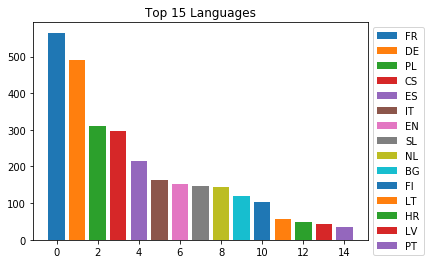

In [18]:
languages = pd.value_counts(df.LG)
for i, lang in enumerate(languages.index[:15]):
    plt.bar(i, languages[lang], label=lang)
    
plt.legend(bbox_to_anchor=(1,1))
plt.title("Top 15 Languages")
plt.show()

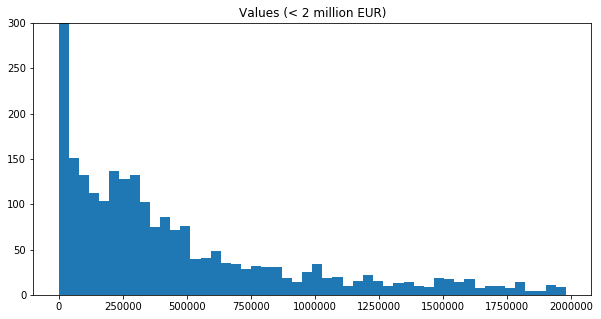

In [73]:
values = df['VALUE_EUR'].astype("float")
plt.figure(figsize=(10,5))
plt.hist(values[values < 2000000] , bins=50)
plt.title("Values (< 2 million EUR)")
plt.ylim(0, 300)
plt.show()

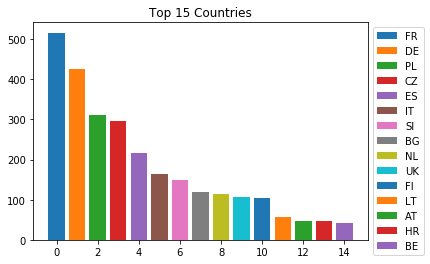

In [20]:
countries = pd.value_counts(df['country'])
for i, country in enumerate(countries.index[:15]):
    plt.bar(i, countries[country], label=country)
    
plt.legend(bbox_to_anchor=(1,1))
plt.title("Top 15 Countries")
plt.show()